#Langkah 1 - Import Library

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models

#Langkah 2 - Load Dataset

In [3]:
# Load images and labels from a directory structure
def load_dataset(img_dir):
    p = Path(img_dir)
    img_list = []
    for folder in p.glob('*'):
        label = folder.name
        for file in folder.glob('*.jpg'):
            img = cv2.imread(str(file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_list.append((img, label))
    return img_list

# Image directories
train_dir = "/content/drive/MyDrive/Colab Notebooks/MLearning/week 11/images/training/"
test_dir = "/content/drive/MyDrive/Colab Notebooks/MLearning/week 11/images/test/"

train_img = load_dataset(train_dir)
test_img  = load_dataset(test_dir)

#Langkah 2 - Pra Pengolahan

In [4]:
# Preprocess images: resize and encode labels
def resize_image(img, size=(256,256)):
    return cv2.resize(img, size)

def label_encoder(label):
    return 1 if label == 'day' else 0

def preprocess(img_list):
    X = []
    y = []
    for img, label in img_list:
        img_std = resize_image(img)
        X.append(img_std)
        y.append(label_encoder(label))
    return X, y

X_train_img, y_train = preprocess(train_img)
X_test_img,  y_test  = preprocess(test_img)

#Langkah 3 - Ekstraksi Fitur

In [5]:
# Extract HOG features
def extract_hog(X_imgs):
    feats = []
    for img in X_imgs:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hog_feat = hog(gray,
                       orientations=9,
                       pixels_per_cell=(8,8),
                       cells_per_block=(2,2),
                       block_norm='L2-Hys',
                       visualize=False,
                       feature_vector=True)
        feats.append(hog_feat)
    return np.array(feats)

X_train_feat = extract_hog(X_train_img)
X_test_feat  = extract_hog(X_test_img)

#Langkah 4 - Standardisasi Fitur

In [6]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled  = scaler.transform(X_test_feat)

#Langkah 5 - Buat Data Latih dan Validasi

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_train,
    test_size=0.2,
    random_state=42
)

# Convert label ke numpy array
y_train = np.array(y_train)
y_val   = np.array(y_val)
y_test  = np.array(y_test)

#Langkah 6 - Buat Model ANN

In [8]:
input_dim = X_train.shape[1]

model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     4,428,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,436,737 (16.92 MB)

 Trainable params: 4,436,737 (16.92 MB)

 Non-trainable params: 0 (0.00 B)

#Langkah 7 - Latih Model


In [9]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.7440 - loss: 1.1048 - val_accuracy: 1.0000 - val_loss: 1.8992e-04
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9878 - loss: 0.0451 - val_accuracy: 1.0000 - val_loss: 2.1190e-05
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9813 - loss: 0.0175 - val_accuracy: 1.0000 - val_loss: 6.8800e-06
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 2.4384e-05 - val_accuracy: 1.0000 - val_loss: 4.7533e-06
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 6.6281e-05 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 5.6982e-06
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 1.0000 - loss: 2.8158e-07 - val_accuracy: 1.0000 - val_loss: 7.2378e-06
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 1.0842e-06 -

#Langkah 8 - Evaluasi Model dengan Data Test

In [10]:
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print("Akurasi Test:", test_acc)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9210 - loss: 0.4606
Akurasi Test: 0.9375


#Langkah 9 - Buat Laporan Performansi Model



In [11]:
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        80
           1       0.97      0.90      0.94        80

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160

[[78  2]
 [ 8 72]]


#Langkah 10 - Visualisasi Proses Training

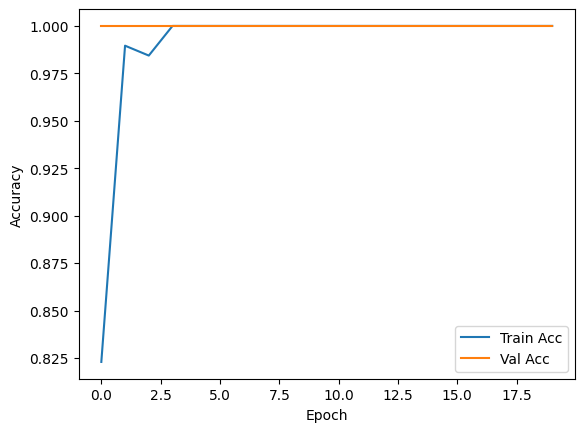

In [12]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

vall acc stabil disemua epoch, sementara train acc mengalami perubahan akurasi kenaikan kemudian menjadi stabil di epoch 3 atau 4

#Langkah 11 - Simpan Model

In [13]:
model.save('day_night_classifier_model.h5')